In [33]:
import pandas as pd
import openreview
import requests
import os
import re
import csv
import pdfplumber
from tqdm import tqdm

In [ ]:
def clean_filename(name: str) -> str:
    # remove special characters
    name = re.sub(r'[<>:"/\\|?*]', '', name)
    name = re.sub(r'\s+', '_', name).strip('_')
    return name

def download_neurips_articles():
    try:
        # initialize openreview client
        client = openreview.api.OpenReviewClient(baseurl='https://api2.openreview.net')

        # set up constants
        ACCEPTED_VENUE_ID = 'NeurIPS.cc/2024/Datasets_and_Benchmarks_Track'
        OUTPUT_DIR = 'NeurIPS2024_Datasets_and_Benchmarks'
        METADATA_CSV_FILE = os.path.join(OUTPUT_DIR, 'metadata.csv')

        # make output directory
        os.makedirs(OUTPUT_DIR, exist_ok=True)

        # get all accepted articles
        print(f"Querying openreview for venue ID: {ACCEPTED_VENUE_ID}")
        notes_iterator = openreview.tools.iterget_notes(client, content={'venueid': ACCEPTED_VENUE_ID})

        #notes_iterator = openreview.tools.iterget_notes(client, content={'venueid': ACCEPTED_VENUE_ID})
        all_notes = list(notes_iterator)
        print(f"Total notes retrieved: {len(all_notes)}")

        if not all_notes:
            print("No accepted articles found")
            return

        # downloading pdfs and metadata, extracting fulltext to .csv
        all_metadata = []
        print(f"Downloading {len(all_notes)} articles to '{OUTPUT_DIR}'")

        for note in tqdm(all_notes):
            try:
                title = note.content['title']['value']
                pdf_url_relative = note.content['pdf']['value']

                pdf_url_full = f"https://openreview.net{pdf_url_relative}"
                pdf_filename = f"{clean_filename(title)}.pdf"
                pdf_path = os.path.join(OUTPUT_DIR, pdf_filename)

                # download pdf
                if not os.path.exists(pdf_path):
                    response = requests.get(pdf_url_full, stream=True)
                    response.raise_for_status()
                    with open(pdf_path, 'wb') as f:
                        for chunk in response.iter_content(chunk_size=8192):
                            f.write(chunk)

                # extract fulltext
                fulltext = ""
                try:
                    with pdfplumber.open(pdf_path) as pdf:
                        fulltext = "\n".join(page.extract_text() or "" for page in pdf.pages)
                except Exception as e:
                    tqdm.write(f"Error extracting fulltext from {pdf_path}: {e}")
                    fulltext = "Could not extract fulltext"

                # collect metadata
                article_metadata = {
                    'title': title,
                    'keywords': note.content.get('keywords', {}).get('value', []),
                    'openreview_url': f"https://openreview.net/forum?id={note.id}",
                    'pdf_filename': pdf_filename,
                    'fulltext': fulltext
                }
                all_metadata.append(article_metadata)

            except Exception as e:
                tqdm.write(f"Error processing article '{note.content.get('title', {}).get('value', 'Unknown')}': {e}")

        if not all_metadata:
            print("No metadata found")
            return

        # save metadata to .csv
        with open(METADATA_CSV_FILE, 'w', newline='', encoding='utf-8') as f:
            writer = csv.DictWriter(f, fieldnames=all_metadata[0].keys())
            writer.writeheader()
            writer.writerows(all_metadata)

        print(f"Metadata saved to '{METADATA_CSV_FILE}'")

    except Exception as e:
        print(f"Error processing articles: {e}")

if __name__ == '__main__':
    download_neurips_articles()
    print("Done")







In [34]:
import pandas as pd
df = pd.read_csv('NeurIPS2024_Datasets_and_Benchmarks/metadata.csv')
df.head()

,title,keywords,openreview_url,pdf_filename,fulltext,representation_mentioned,diversity_mentioned,similarity_mentioned
0,DevBench: A multimodal developmental benchmark...,"['multimodal', 'developmental', 'language', 'e...",https://openreview.net/forum?id=zogaeVpbaE,DevBench_A_multimodal_developmental_benchmark_...,DEVBENCH: A multimodal developmental benchmark...,1,1,1
1,Point Cloud Matters: Rethinking the Impact of ...,"['Point Cloud', 'RGB-D images', 'Robot Learnin...",https://openreview.net/forum?id=zgSnSZ0Re6,Point_Cloud_Matters_Rethinking_the_Impact_of_D...,Point Cloud Matters: Rethinking the Impact of\...,1,1,1
2,XLand-MiniGrid: Scalable Meta-Reinforcement Le...,"['reinforcement learning', 'meta-reinforcement...",https://openreview.net/forum?id=zg8dpAGl1I,XLand-MiniGrid_Scalable_Meta-Reinforcement_Lea...,XLand-MiniGrid: Scalable Meta-Reinforcement\nL...,1,1,1
3,kGym: A Platform and Dataset to Benchmark Larg...,"['Benchmarks', 'Datasets', 'Natural Language P...",https://openreview.net/forum?id=zQ3qU0xWZ5,kGym_A_Platform_and_Dataset_to_Benchmark_Large...,KGYM: A Platform and Dataset to Benchmark Larg...,1,1,1
4,$E^3$: Exploring Embodied Emotion Through A La...,['emotion analysis; egocentric datasets ; vide...,https://openreview.net/forum?id=zGfKPqunJG,$E^3$_Exploring_Embodied_Emotion_Through_A_Lar...,E3\n: Exploring Embodied Emotion Through\nA La...,1,1,0


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   title                     459 non-null    object
 1   keywords                  459 non-null    object
 2   openreview_url            459 non-null    object
 3   pdf_filename              459 non-null    object
 4   fulltext                  459 non-null    object
 5   representation_mentioned  459 non-null    int64 
 6   diversity_mentioned       459 non-null    int64 
 7   similarity_mentioned      459 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 28.8+ KB


In [36]:
# checking for failed fulltext extractions
empty_mask = df['fulltext'].fillna('').str.strip() == ''
missing_fulltext = df.loc[empty_mask, ['title', 'pdf_filename']]

if missing_fulltext.empty:
    print("No failed fulltext extractions")
else:
    print("Failed fulltext extractions:")
    print(missing_fulltext)

Failed fulltext extractions:
                                                 title  \
180  LINGOLY: A Benchmark of Olympiad-Level Linguis...   

                                          pdf_filename  
180  LINGOLY_A_Benchmark_of_Olympiad-Level_Linguist...  


In [ ]:
"""
# The failed fulltext extraction seems to be image-based. Will use tesseract to extract text instead.
# I will manually input the fulltext into the .csv file, since it is only one article.
import pytesseract
from pdf2image import convert_from_path
import os

def extract_text_from_image_pdf(pdf_path):
    try:
        images = convert_from_path(pdf_path)
        full_text = ""
        for i, image in enumerate(images):
            print(f"   - Reading page {i + 1}/{len(images)}")
            text = pytesseract.image_to_string(image)
            full_text += text + "\n\n" # Add page breaks

        print(full_text)

    except Exception as e:
        print(f"An error occurred during OCR processing: {e}")
        print("Please ensure Tesseract is installed and accessible in your system's PATH.")


if __name__ == "__main__":
    filename = "LINGOLY_A_Benchmark_of_Olympiad-Level_Linguistic_Reasoning_Puzzles_in_Low_Resource_and_Extinct_Languages.pdf"
    folder = "NeurIPS2024_Datasets_and_Benchmarks"
    file_to_process = os.path.join(folder, filename)

    extract_text_from_image_pdf(file_to_process)
"""

In [ ]:
#removing the row where the fulltext is empty
df.to_csv('NeurIPS2024_Datasets_and_Benchmarks/backup_metadata.csv', index=False)

In [37]:
row = df.iloc[180]
print(row['title'])
df.info()

LINGOLY: A Benchmark of Olympiad-Level Linguistic Reasoning Puzzles in Low Resource and Extinct Languages
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   title                     459 non-null    object
 1   keywords                  459 non-null    object
 2   openreview_url            459 non-null    object
 3   pdf_filename              459 non-null    object
 4   fulltext                  459 non-null    object
 5   representation_mentioned  459 non-null    int64 
 6   diversity_mentioned       459 non-null    int64 
 7   similarity_mentioned      459 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 28.8+ KB


In [38]:
# SIKRE AT DET ER DET RIGTIGE INDEx!!!!
df = df.drop(df.index[180])

In [39]:
row = df.iloc[180]
print(row['title'])
df.info()

WebUOT-1M: Advancing Deep Underwater Object Tracking with A Million-Scale Benchmark
<class 'pandas.core.frame.DataFrame'>
Int64Index: 458 entries, 0 to 458
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   title                     458 non-null    object
 1   keywords                  458 non-null    object
 2   openreview_url            458 non-null    object
 3   pdf_filename              458 non-null    object
 4   fulltext                  458 non-null    object
 5   representation_mentioned  458 non-null    int64 
 6   diversity_mentioned       458 non-null    int64 
 7   similarity_mentioned      458 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 32.2+ KB


In [ ]:
def add_word_column():
    file_path = os.path.join('NeurIPS2024_Datasets_and_Benchmarks', 'metadata.csv')

    search_terms = {
        'representation_mentioned': r'represent',
        'diversity_mentioned': r'divers',
        'similarity_mentioned': r'similar',
    }

    try:
        print(f"Reading file: {file_path}")
        df = pd.read_csv(file_path)

        for column_name, pattern in search_terms.items():
            df[column_name] = df['fulltext'].str.contains(
                pattern,
                case=False,
                regex=True
            ).astype(int)

        df.to_csv(file_path, index=False)

        #checking the results
        print(df[['title'] + list(search_terms.keys())].head())

    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    add_word_column()

In [ ]:
df2 = pd.read_csv('NeurIPS2024_Datasets_and_Benchmarks/metadata.csv')
df2.info()

In [ ]:
#checking how many articles contain each of the three words and their frequency
word_columns = ['representation_mentioned', 'diversity_mentioned', 'similarity_mentioned']
total_articles = len(df2)

for col in word_columns:
    count = df2[col].sum()
    percentage = (count / total_articles) * 100
    print(f"Number of articles containing '{col}': {count}")
    print(f"Percentage of articles containing '{col}': {percentage:.2f}%")

combination_counts = df2.groupby(word_columns).size().reset_index(name='article_count')
combination_counts = combination_counts.sort_values(by='article_count', ascending=False)

print("Combination of word mentions (1=mentioned, 0=not mentioned):")
print(combination_counts.to_string(index=False))

In [ ]:
"""
row = df2.iloc[180]
print(row['title'])
df2.head()
"""

In [ ]:
#checking which article uses none of the three words
no_mentions_mask = df2[word_columns].sum(axis=1) == 0
articles_with_no_mentions = df2[no_mentions_mask]
print(articles_with_no_mentions[['title', 'pdf_filename']])



In [ ]:
#checking the frequency of different keywords from article metadata
from collections import Counter

cleaned_keywords = (
    df2['keywords']
    .str.lower()  #lowercase
    .str.replace(r"[\[\]']", "", regex=True)  #remove brackets and quotes
    .str.split(',')
    .explode()
    .str.strip()  #remove leading/trailing whitespace
)

#counting frequencies
keyword_counts = cleaned_keywords.value_counts()
keyword_counts = keyword_counts[keyword_counts.index != '']
print("Keyword frequencies:")
print(keyword_counts.head(20))

In [ ]:
df2 = pd.read_csv('NeurIPS2024_Datasets_and_Benchmarks/metadata.csv')
df2.info()

In [ ]:
row = df2.iloc[180]
print(row['title'])
df2.info()

In [ ]:
df = df2.drop(df2.index[180])
row = df.iloc[180]
print(row['title'])

In [40]:
def remove_bibliography(text: str) -> str:
    #making sure text is a string
    if not isinstance(text, str):
        return ""

    start_pattern = re.compile(r'(references|bibliography)', re.IGNORECASE | re.MULTILINE)
    end_pattern = re.compile(r'(appendix|appendices|neurips paper checklist|neuripspaperchecklist)', re.IGNORECASE | re.MULTILINE)

    start_match = start_pattern.search(text)

    if not start_match:
        return text

    bib_start_index = start_match.start()
    search_from_index = start_match.end()
    end_match = end_pattern.search(text, pos=search_from_index)


    if end_match:
        bib_end_index = end_match.start()
        #reconstruct text
        text_before_bib = text[:bib_start_index]
        text_after_bib_section = text[bib_end_index:]
        return text_before_bib + text_after_bib_section
    else:
        return text[:bib_start_index]

#creating new column with cleaned text
df['fulltext_no_bib'] = df['fulltext'].apply(remove_bibliography)

#checking if the function works
sample_article = df.iloc[155]
original_length = len(sample_article['fulltext'])
cleaned_length = len(sample_article['fulltext_no_bib'])

print(f"Sample article title: {sample_article['title']}")
print(f"Original fulltext length: {original_length} characters")
print(f"Cleaned fulltext length:  {cleaned_length} characters")
print(f"Characters removed:       {original_length - cleaned_length}")

Sample article title: A Retrospective on the Robot Air Hockey Challenge: Benchmarking Robust, Reliable, and Safe Learning Techniques for Real-world Robotics
Original fulltext length: 109756 characters
Cleaned fulltext length:  95991 characters
Characters removed:       13765


In [41]:
#comparing the fulltext and fulltext_no_bib columns
import difflib

try:
    original_text = sample_article['fulltext']
    cleaned_text = sample_article['fulltext_no_bib']

    diff = difflib.unified_diff(original_text.splitlines(keepends=True), cleaned_text.splitlines(keepends=True), fromfile='original', tofile='no_bib', lineterm='')

    print("Comparison:")
    diff_output = ''.join(diff)
    print(diff_output)

except Exception as e:
    print(f"Error comparing fulltext and fulltext_no_bib: {e}")

Comparison:
--- original+++ no_bib@@ -529,201 +529,6 @@ • SpaceR—AndrejOrsula,MiguelOlivares-Mendez
 • RL3_polimi — Amarildo Likmeta, Amirhossein Zhalehmehrabi, Thomas Jean Bernard
 Bonenfant,AlessandroMontenegro,DavideSalaorni,MarcelloRestelli
-References
-ZhilinYang,ZihangDai,YimingYang,JaimeCarbonell,RussRSalakhutdinov,andQuocVLe.
-Xlnet: Generalizedautoregressivepretrainingforlanguageunderstanding. Advancesinneural
-informationprocessingsystems,32,2019.
-TomBrown,BenjaminMann,NickRyder,MelanieSubbiah,JaredDKaplan,PrafullaDhariwal,
-ArvindNeelakantan,PranavShyam,GirishSastry,AmandaAskell,etal. Languagemodelsare
-few-shotlearners. Advancesinneuralinformationprocessingsystems,33:1877–1901,2020.
-JoshAchiam,StevenAdler,SandhiniAgarwal,LamaAhmad,IlgeAkkaya,FlorenciaLeoniAleman,
-DiogoAlmeida,JankoAltenschmidt,SamAltman,ShyamalAnadkat,etal. Gpt-4technicalreport.
-arXivpreprintarXiv:2303.08774,2023.
-DavidSilver,AjaHuang,ChrisJMaddison,ArthurGuez,LaurentSifre,GeorgeVanDenDriessche,
-Julia

In [ ]:
#not perfect... but I think it works for now

In [42]:
#updating word mention columns based on 'fulltext_no_bib'
search_terms = {
    'representativity_mentioned': r'represent',
    'diversity_mentioned': r'divers',
    'similarity_mentioned': r'similar'
}
word_columns = list(search_terms.keys())

print("\nUpdating keyword columns based on 'fulltext_no_bib'...")

df['fulltext_no_bib'] = df['fulltext_no_bib'].astype(str).fillna('')

for column_name, pattern in search_terms.items():
    df[column_name] = df['fulltext_no_bib'].str.contains(
        pattern,
        case=False,
        regex=True
    ).astype(int)

total_articles = len(df)



for col in word_columns:
    count = df[col].sum()
    percentage = (count / total_articles) * 100
    print(f"Number of articles containing '{col}': {count}")
    print(f"Percentage of articles containing '{col}': {percentage:.2f}%")

combination_counts = df.groupby(word_columns).size().reset_index(name='article_count')
combination_counts = combination_counts.sort_values(by='article_count', ascending=False)

print("Combination of word mentions (1=mentioned, 0=not mentioned):")
print(combination_counts.to_string(index=False))



Updating keyword columns based on 'fulltext_no_bib'...
Number of articles containing 'representativity_mentioned': 439
Percentage of articles containing 'representativity_mentioned': 95.85%
Number of articles containing 'diversity_mentioned': 415
Percentage of articles containing 'diversity_mentioned': 90.61%
Number of articles containing 'similarity_mentioned': 418
Percentage of articles containing 'similarity_mentioned': 91.27%
Combination of word mentions (1=mentioned, 0=not mentioned):
 representativity_mentioned  diversity_mentioned  similarity_mentioned  article_count
                          1                    1                     1            375
                          1                    0                     1             31
                          1                    1                     0             28
                          0                    1                     1              9
                          1                    0                     0    

In [43]:
#removing duplicates in keywords column
from collections import Counter

normalization_map = {
    'large language model': 'large language model',
    'large language models': 'large language model',
    'llm': 'large language model',
    'llms': 'large language model',
    'multimodal large language models': 'large language model',
    'benchmark': 'benchmark',
    'benchmarks': 'benchmark',
    'benchmarking': 'benchmark',
    'dataset': 'dataset',
    'datasets': 'dataset',
    'vision-language models': 'vision-language'
}

def normalize_keyword(keyword):
    #normalizing keywords
    return normalization_map.get(keyword, keyword)


cleaned_keywords = (
    df['keywords']
    .str.lower()
    .str.replace(r"[\[\]']", "", regex=True)
    .str.split(',')
    .explode()
    .str.strip()
)

#applying normalization
normalized_keywords = cleaned_keywords.apply(normalize_keyword)

#count frequencies and remove empty strings
keyword_counts_normalized = normalized_keywords.value_counts()
keyword_counts_normalized = keyword_counts_normalized[keyword_counts_normalized.index != '']

print("Updated keyword frequencies:")
print(keyword_counts_normalized.head(20))

Updated keyword frequencies:
benchmark                 107
large language model       91
dataset                    48
evaluation                 20
vision-language            15
reinforcement learning     15
multimodal                 14
computer vision            12
machine learning           10
remote sensing              8
synthetic data              7
graph neural networks       7
healthcare                  6
rag                         6
foundation models           5
alignment                   5
language models             5
code generation             5
robustness                  5
semantic segmentation       5
Name: keywords, dtype: int64


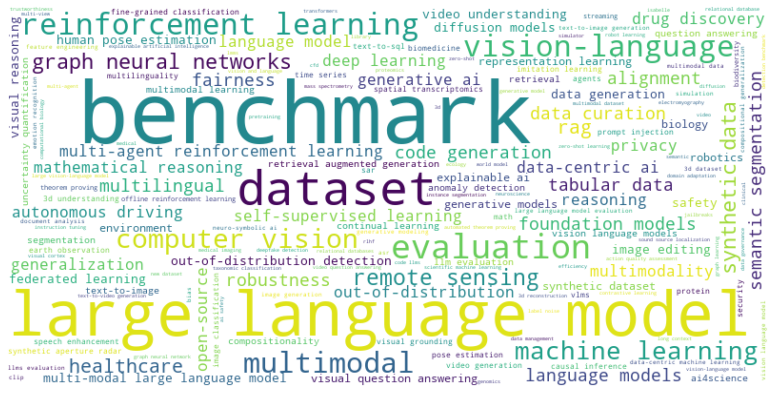

Wordcloud on keywords.


In [44]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    collocations=False
).generate_from_frequencies(keyword_counts_normalized.to_dict())


plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print("Wordcloud on keywords.")

In [ ]:
#TODO
#FINISH ARTICLE CODING/ANNOTATION
#ADD COLUMN WITH PARAGRAPHS WHERE WORDS ARE MENTIONED
#WRITE ARTICLE :))